# HTA figs of varying horizontal resolutions
Coarse graining the tracer fields to varying resolutions to determine the effect of scales on the HTA

## Table Of Contents:<a class="anchor" id="top"></a>

* [Calculate HTA for various resolutions](#hta)
* [Plot HTA for each resolution](#plt-hta)
    * [Plotting difference between orig and coarse](#sub2)
* [Basin-wide annual-mean](#third-bullet)
    * [Atlantic ocean](#ATL)
    * [Indian ocean](#IND)
    * [Pacific ocean](#PAC)
    * [Southern ocean](#SO)

In [1]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [2]:
client

<Client: 'tls://10.8.23.5:8786' processes=0 threads=0, memory=0 B>

In [12]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import json
import fsspec
import gcsfs
import gcm_filters
import pop_tools

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU', 'time']])

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

filtered_res = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/filtered_res.zarr'))

In [5]:
filtered_res

<xarray.Dataset>
Dimensions:    (nlat: 2400, nlon: 3600, time: 365)
Coordinates:
    DXT        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTE        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTN        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUS        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUW        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
  * time       (time) object 0046-01-02 00:00:00 ... 0047-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_100km  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS_10km   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS_300km  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_100km  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_10km   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_300km  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

# 1) Calculate HTA for various resolutions<a class='anchor' id='hta'></a>

In [63]:
time_slice = dict(time=slice(0, 365)) #first year

ds_1 = xr.merge([filtered_res, ds_drop.SST.isel(**time_slice).rename('SST'), ds_drop.SSS.isel(**time_slice).rename('SSS')])

In [64]:
#assigning same attrs to the coars res da's so that pop-grid can work on every variable

ds_attrs = ds_1.copy()
for i in list(ds_1): ds_attrs[i] = ds_1[i].assign_attrs(ds_drop.SST.attrs)

In [65]:
ds_attrs

<xarray.Dataset>
Dimensions:    (nlat: 2400, nlon: 3600, time: 365)
Coordinates:
    DXT        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTE        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTN        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUS        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUW        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
  * time       (time) object 0046-01-02 00:00:00 ... 0047-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_100km  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS_10km   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS_300km  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_100km  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_10km   (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_300km  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS        (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [66]:
import hta

In [67]:
hta_orig_res = hta.horizontal_turner_angle(ds_attrs, 'SST', 'SSS')
hta_10km = hta.horizontal_turner_angle(ds_attrs, 'SST_10km', 'SSS_10km')
hta_100km = hta.horizontal_turner_angle(ds_attrs, 'SST_100km', 'SSS_100km')
hta_300km = hta.horizontal_turner_angle(ds_attrs, 'SST_300km', 'SSS_300km')

In [68]:
hta_orig_res_mean = hta_orig_res.mean('time').load()
hta_10km_mean = hta_10km.mean('time').load()
hta_100km_mean = hta_100km.mean('time').load()
hta_300km_mean = hta_300km.mean('time').load()

In [69]:
hta_orig = (-hta_orig_res_mean/2)
hta_10km_sign = (-hta_10km_mean/2)
hta_100km_sign = (-hta_100km_mean/2)
hta_300km_sign = (-hta_300km_mean/2)

In [72]:
hta_ds = xr.merge([hta_orig.rename('orig'), hta_10km_sign.rename('10km'),
                   hta_100km_sign.rename('100km'), hta_300km_sign.rename('300km')])

In [73]:
hta_ds

<xarray.Dataset>
Dimensions:  (nlon_t: 3600, nlat_t: 2400)
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
    DXT      (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    DYT      (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    KMT      (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    TAREA    (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
Data variables:
    orig     (nlat_t, nlon_t) float64 nan nan nan nan nan ... nan nan nan nan
    10km     (nlat_t, nlon_t) float64 nan nan nan nan nan ... nan nan nan nan
    100km    (nlat_t, nlon_t) float64 nan nan nan nan nan ... nan nan nan nan
    300km    (nlat_t, nlon_t) float64 nan nan nan nan nan ... nan nan nan nan

[Back to top](#top)

# 2) Plot HTA for each resolution<a class='anchor' id='plt-hta'></a>

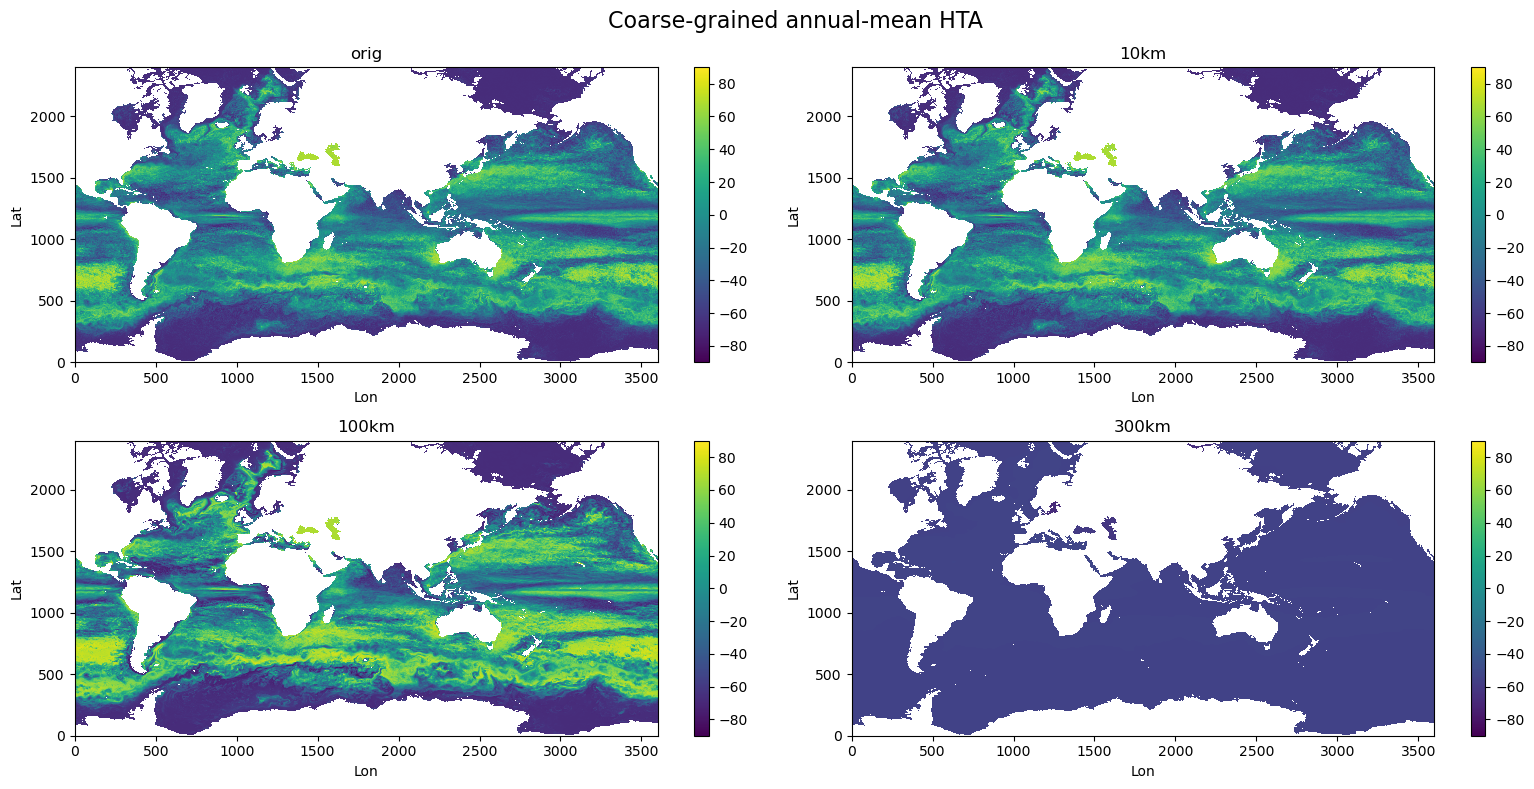

2022-09-29 17:44:45,854 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [110]:
plot_term_titles = np.array([['orig', '10km'],['100km', '300km']])
plot_terms = xr.DataArray([[hta_ds.orig, hta_ds['10km']], [hta_ds['100km'], hta_ds['300km']]])

fig, axes = plt.subplots(2, 2, figsize=(16,8))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.plot(vmin=-90, vmax=90, ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
plt.suptitle('Coarse-grained annual-mean HTA', fontsize=16)
plt.tight_layout();

## Plotting the difference between original resolution and coarse<a class='anchor' id='sub2'> </a>

In [104]:
orig_10km = hta_orig - hta_10km_sign
orig_100km = hta_orig - hta_100km_sign
orig_300km = hta_orig - hta_300km_sign

hta_diff = xr.merge([hta_orig.rename('orig'), orig_10km.rename('orig_10km'),
                     orig_100km.rename('orig_100km'), orig_300km.rename('orig_300km')])

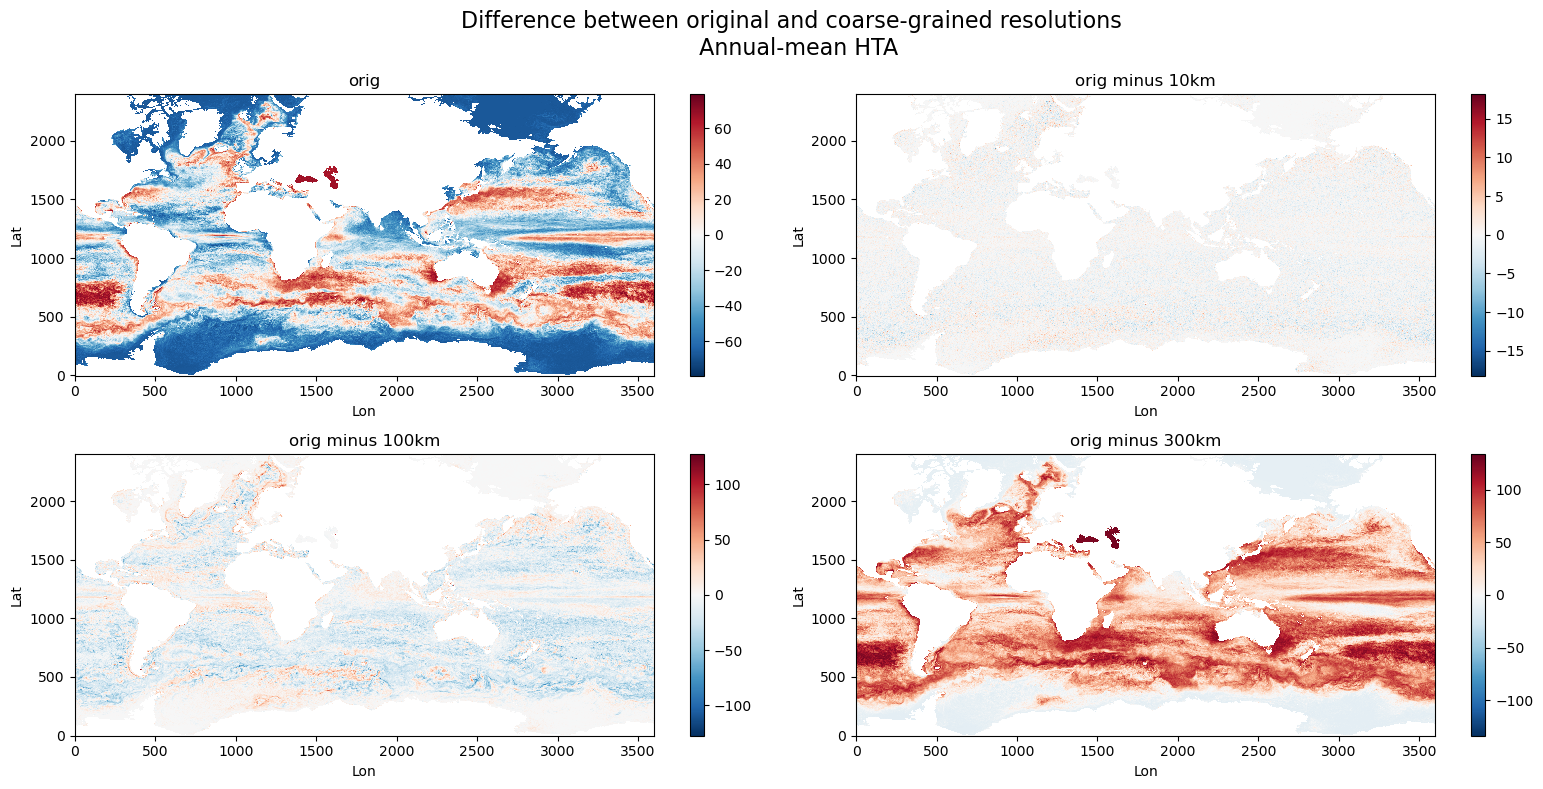

In [107]:
plot_term_titles = np.array([['orig', 'orig minus 10km'],['orig minus 100km', 'orig minus 300km']])
plot_terms = xr.DataArray([[hta_diff.orig, hta_diff.orig_10km], [hta_diff.orig_100km, hta_diff.orig_300km]])

fig, axes = plt.subplots(2, 2, figsize=(16,8))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.plot(ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
        
plt.suptitle('Difference between original and coarse-grained resolutions \n Annual-mean HTA', fontsize=16)
plt.tight_layout();

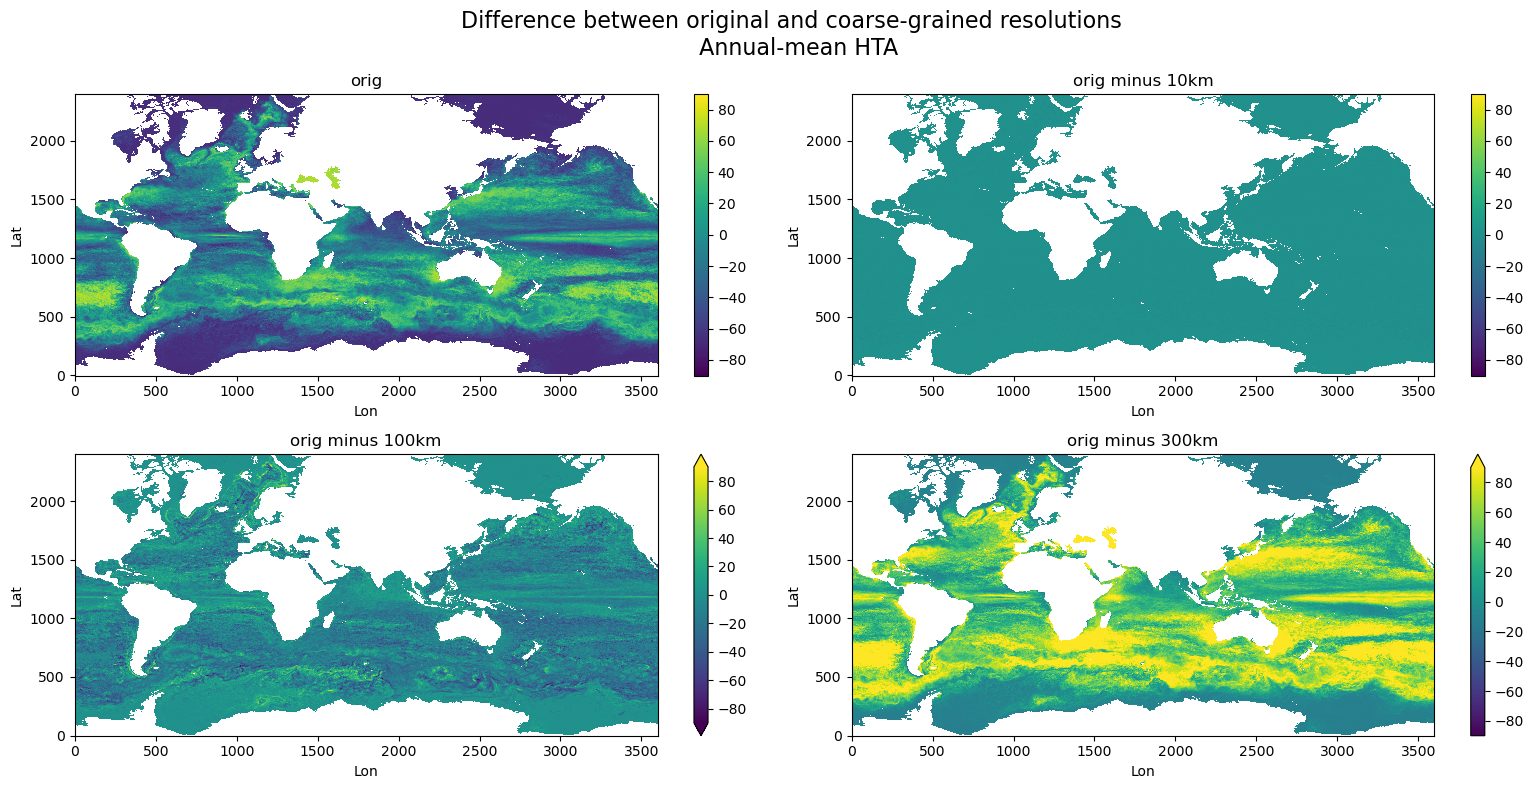

In [108]:
plot_term_titles = np.array([['orig', 'orig minus 10km'],['orig minus 100km', 'orig minus 300km']])
plot_terms = xr.DataArray([[hta_diff.orig, hta_diff.orig_10km], [hta_diff.orig_100km, hta_diff.orig_300km]])

fig, axes = plt.subplots(2, 2, figsize=(16,8))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.plot(vmin=-90, vmax=90, ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
        
plt.suptitle('Difference between original and coarse-grained resolutions \n Annual-mean HTA', fontsize=16)
plt.tight_layout();

# 3) Basin-wide annual-mean<a class='anchor' id='third-bullet'> </a>
Plotting annual-mean and difference between original and coarser resolutions

## Atlantic <a class='anchor' id='ATL'> </a>

In [126]:
levels = np.arange(-90, 90, 15)

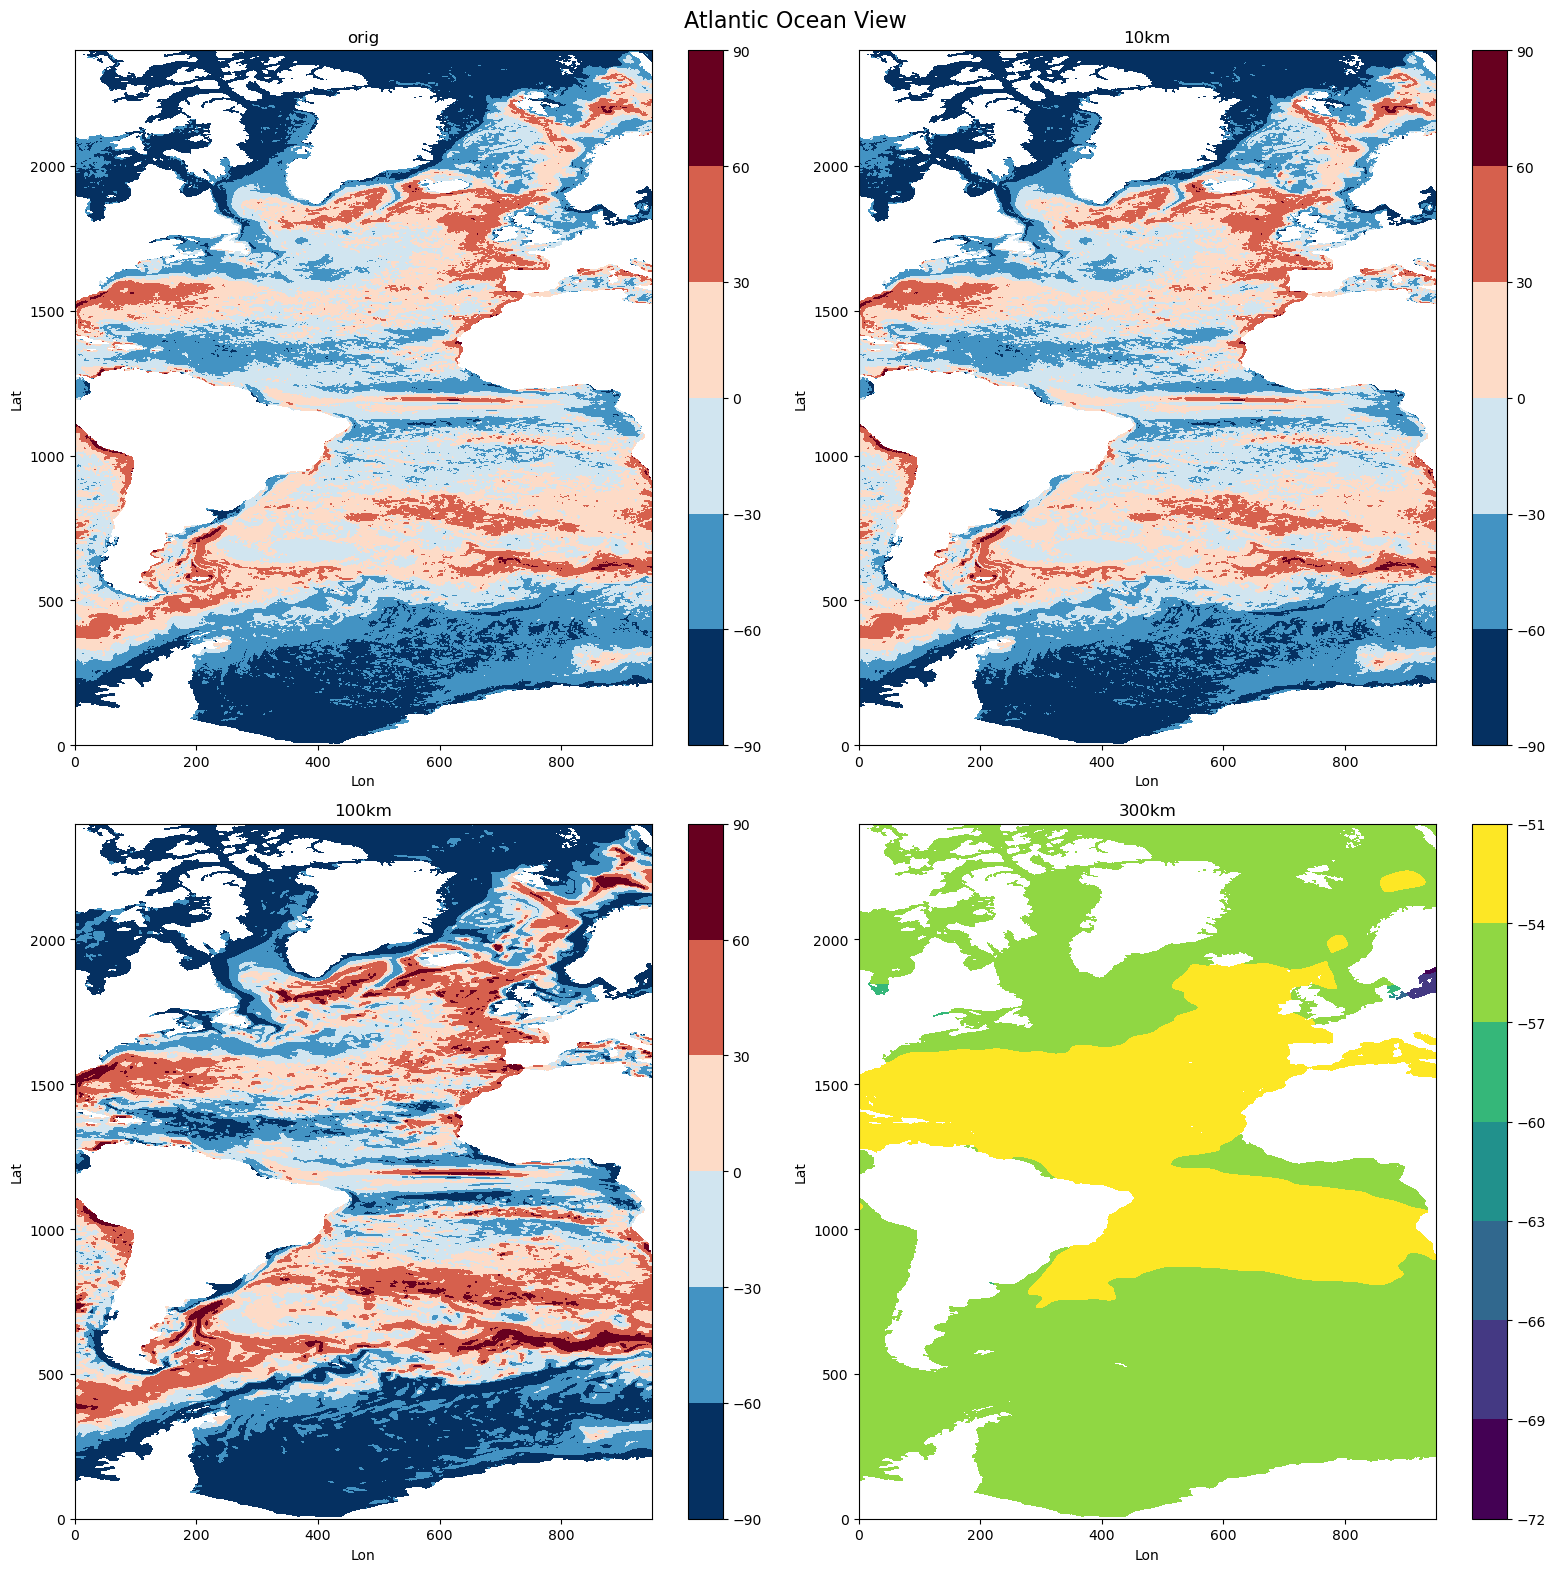

In [127]:
#ATL ocean
sel_lon = dict(dim_3=slice(300,1250))
plot_term_titles = np.array([['orig', '10km'],['100km', '300km']])
plot_terms = xr.DataArray([[hta_ds.orig, hta_ds['10km']], [hta_ds['100km'], hta_ds['300km']]])

fig, axes = plt.subplots(2, 2, figsize=(16,16))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.isel(**sel_lon).plot.contourf(ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
plt.suptitle('Atlantic Ocean View', fontsize=16)
plt.tight_layout();

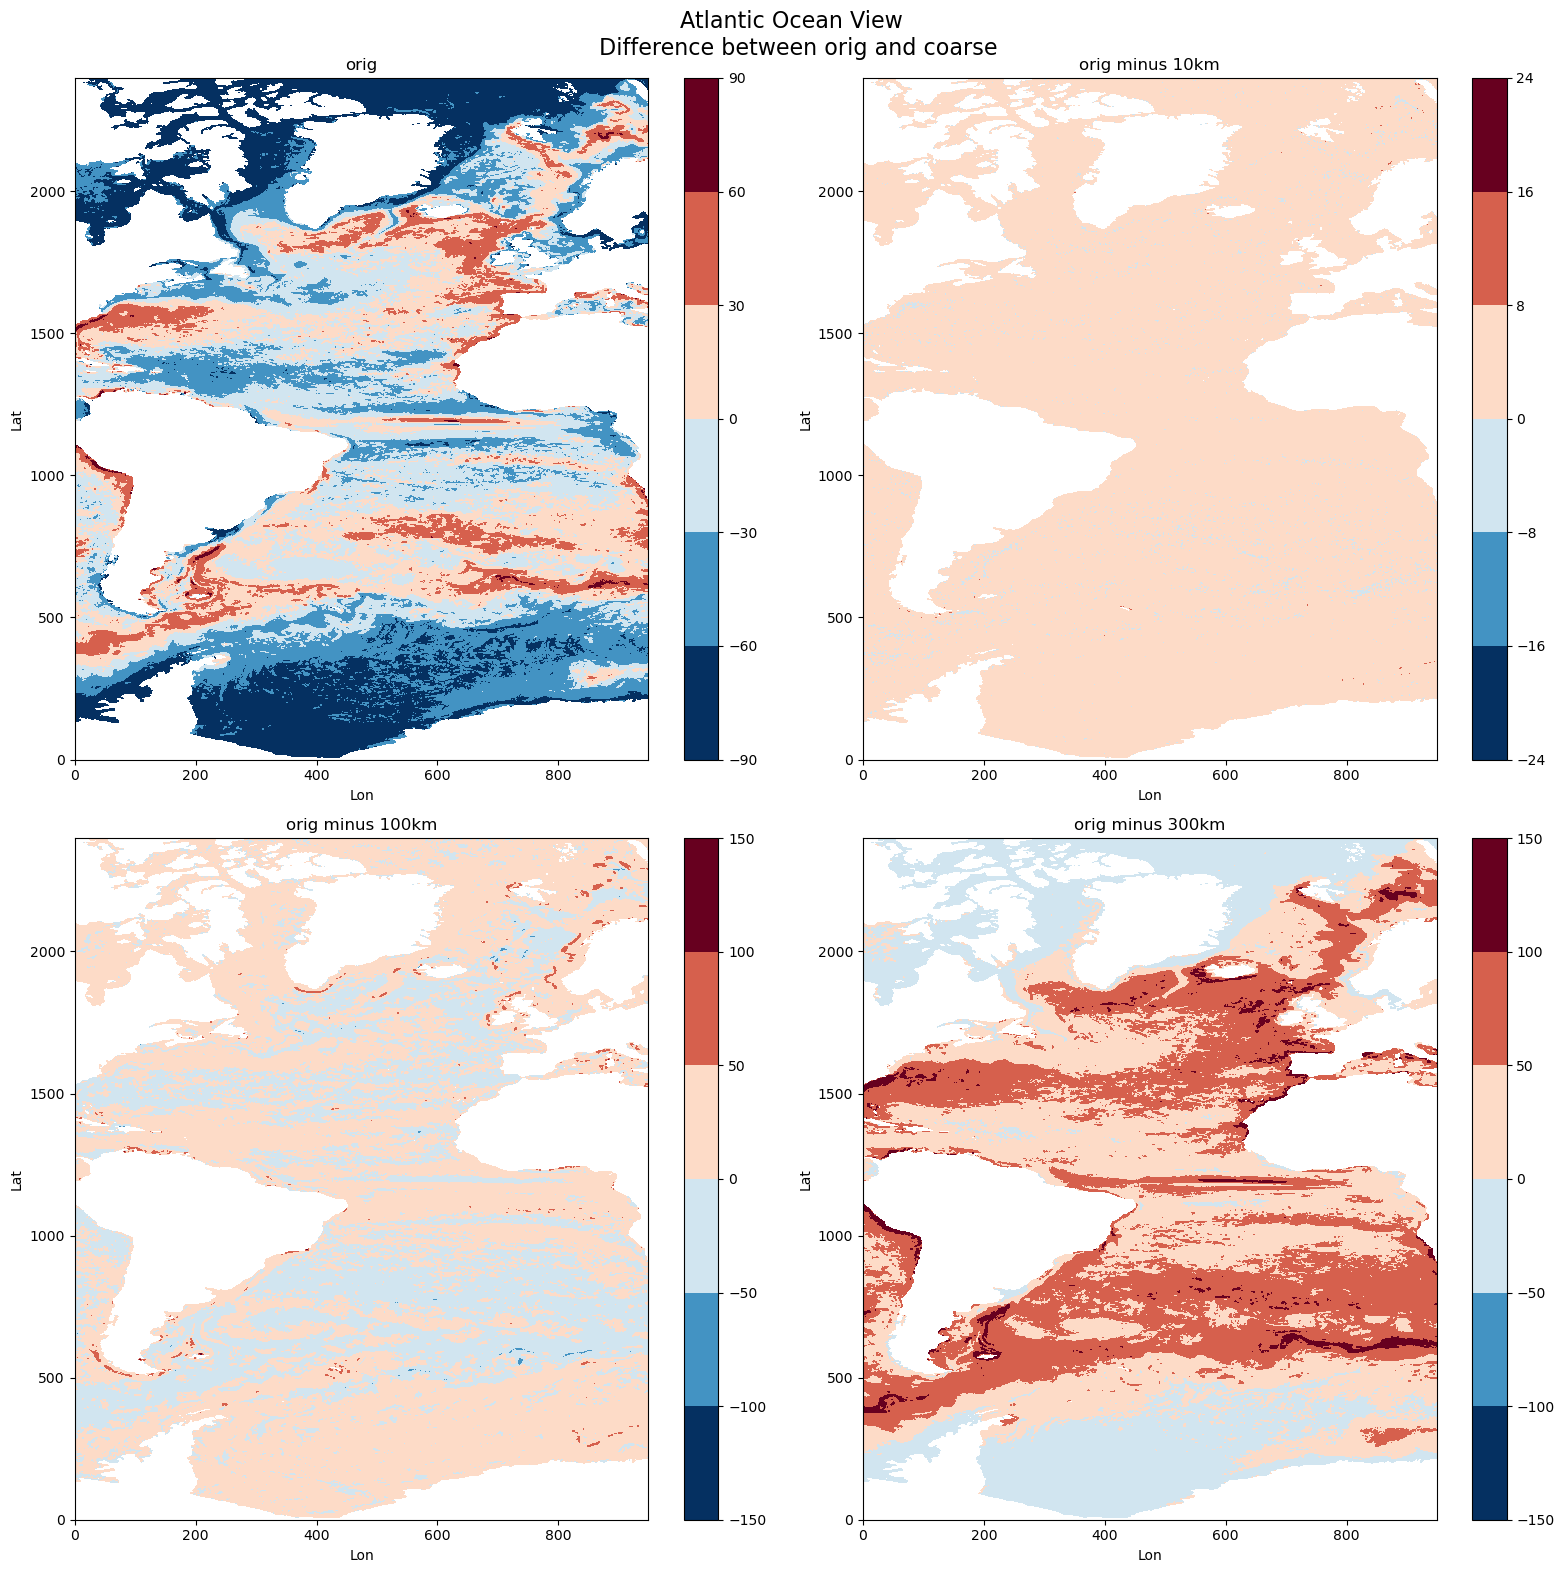

In [128]:
#ATL ocean
sel_lon = dict(dim_3=slice(300,1250))
plot_term_titles = np.array([['orig', 'orig minus 10km'],['orig minus 100km', 'orig minus 300km']])
plot_terms = xr.DataArray([[hta_diff.orig, hta_diff.orig_10km], [hta_diff.orig_100km, hta_diff.orig_300km]])

fig, axes = plt.subplots(2, 2, figsize=(16,16))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.isel(**sel_lon).plot.contourf(ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
        
plt.suptitle('Atlantic Ocean View \n Difference between orig and coarse', fontsize=16)
plt.tight_layout();

## Indian <a class='anchor' id='IND'> </a>

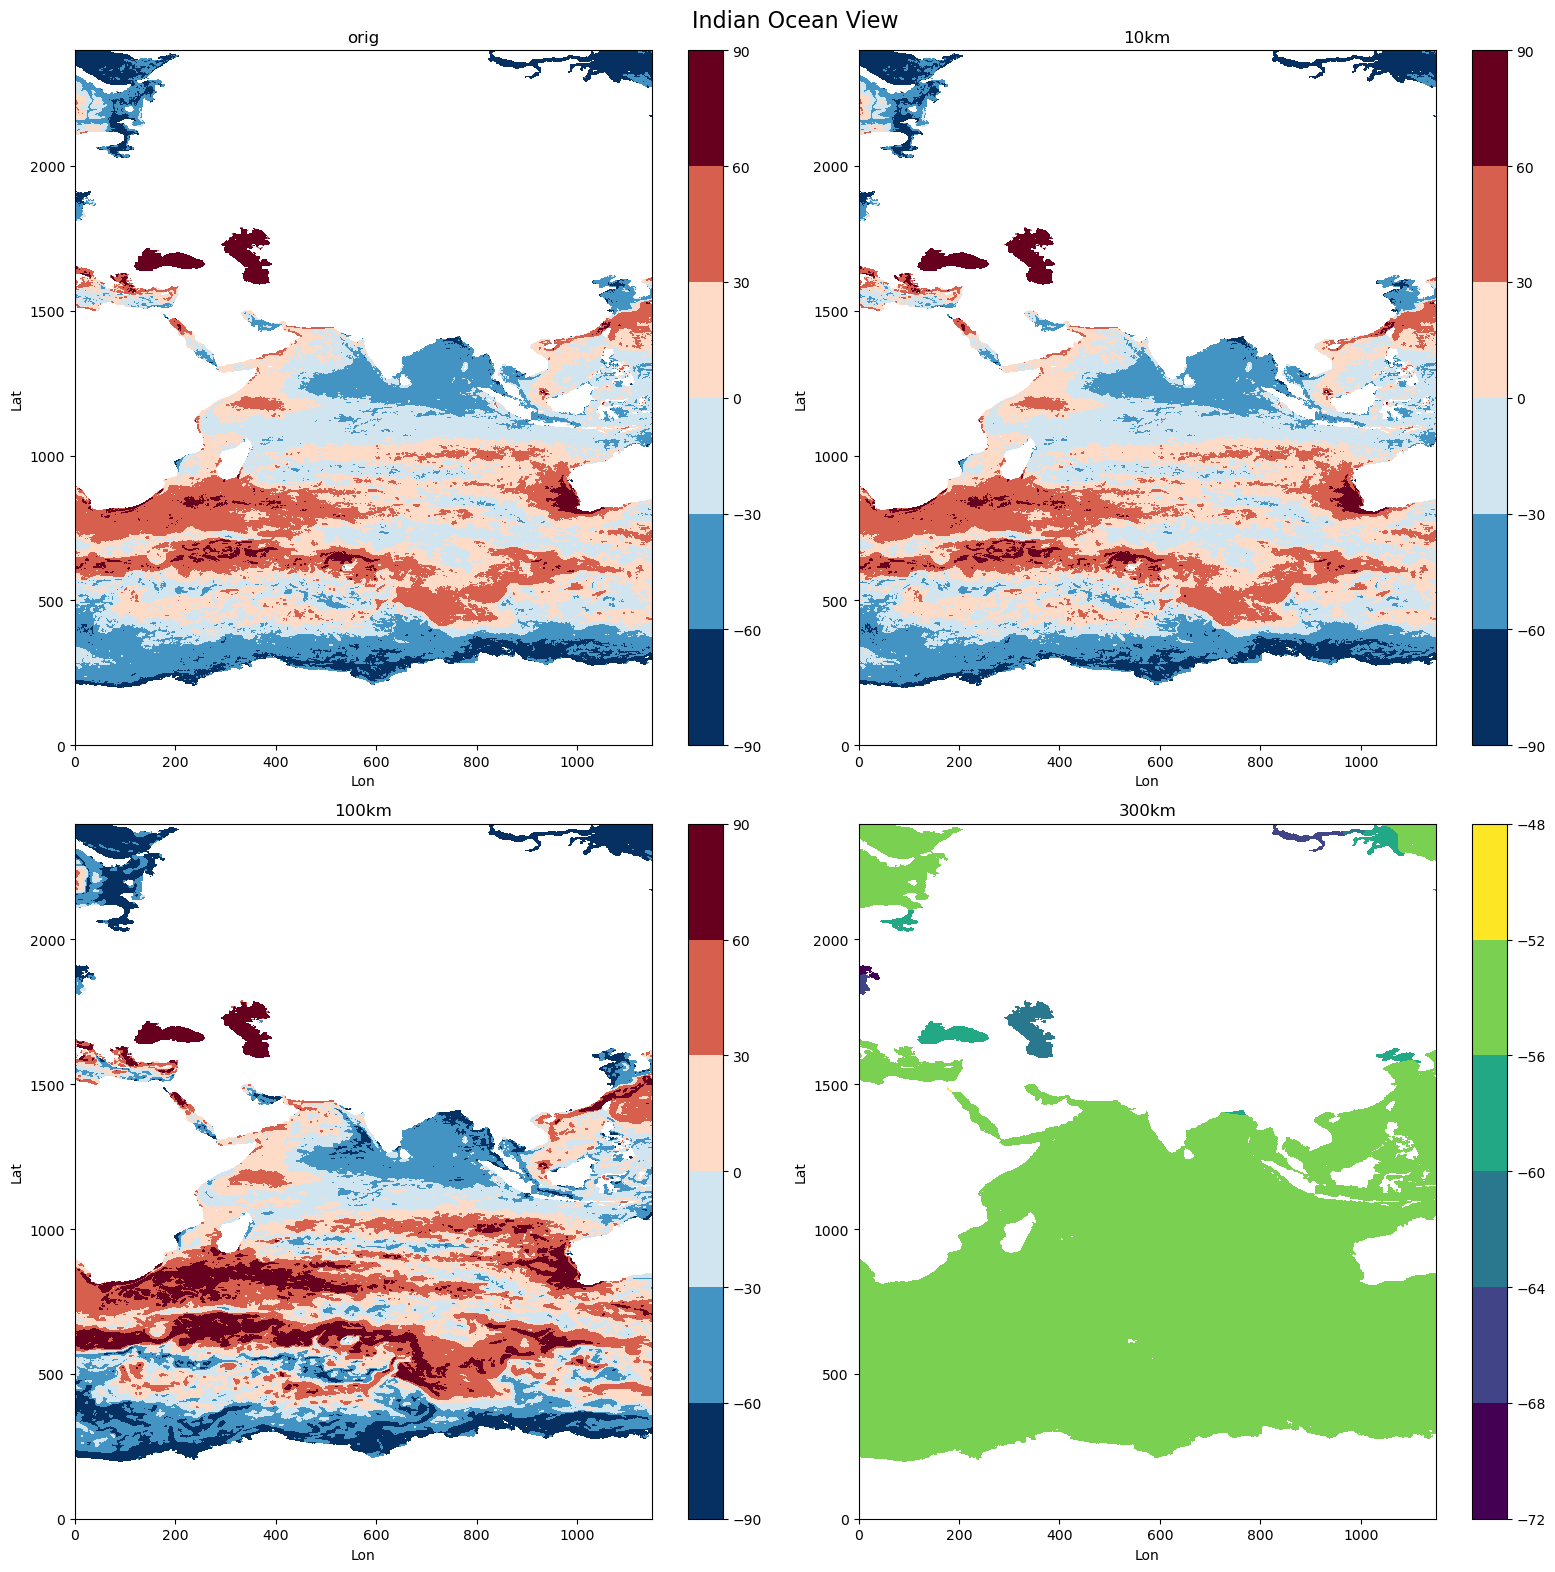

In [123]:
#IND ocean
sel_lon = dict(dim_3=slice(1250, 2400))
plot_term_titles = np.array([['orig', '10km'],['100km', '300km']])
plot_terms = xr.DataArray([[hta_ds.orig, hta_ds['10km']], [hta_ds['100km'], hta_ds['300km']]])

fig, axes = plt.subplots(2, 2, figsize=(16,16))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.isel(**sel_lon).plot.contourf(ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
plt.suptitle('Indian Ocean View', fontsize=16)
plt.tight_layout();

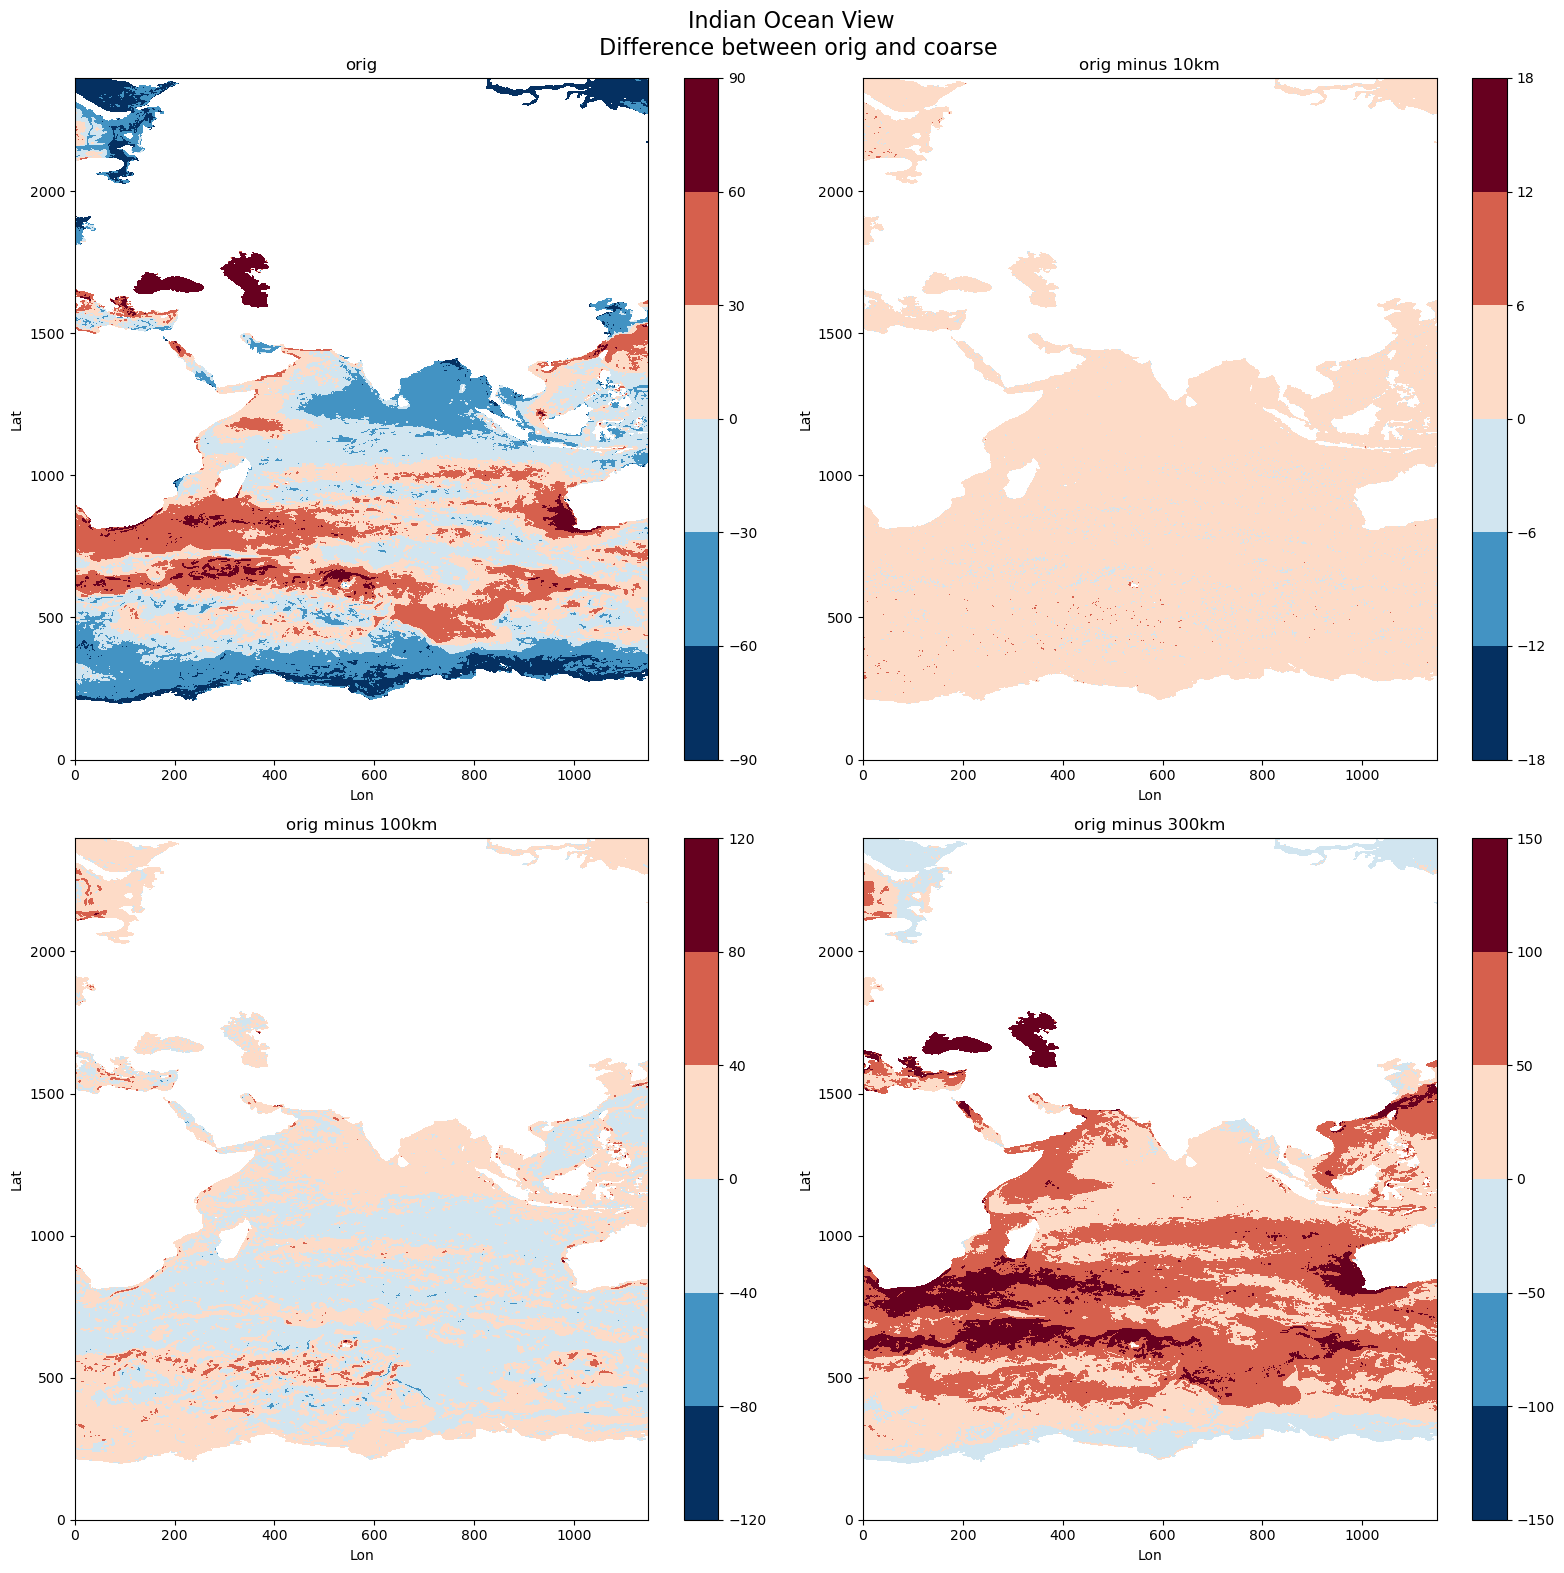

In [124]:
#IND ocean
sel_lon = dict(dim_3=slice(1250, 2400))
plot_term_titles = np.array([['orig', 'orig minus 10km'],['orig minus 100km', 'orig minus 300km']])
plot_terms = xr.DataArray([[hta_diff.orig, hta_diff.orig_10km], [hta_diff.orig_100km, hta_diff.orig_300km]])

fig, axes = plt.subplots(2, 2, figsize=(16,16))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.isel(**sel_lon).plot.contourf(ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
        
plt.suptitle('Indian Ocean View \n Difference between orig and coarse', fontsize=16)
plt.tight_layout();

## Pacific<a class='anchor' id='PAC'> </a>

In [136]:
hta_ds

<xarray.Dataset>
Dimensions:  (nlon_t: 3600, nlat_t: 2400)
Coordinates:
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 ... 3.598e+03 3.598e+03 3.6e+03
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 ... 2.398e+03 2.398e+03 2.4e+03
    DXT      (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    DYT      (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    KMT      (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
    TAREA    (nlat_t, nlon_t) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
Data variables:
    orig     (nlat_t, nlon_t) float64 nan nan nan nan nan ... nan nan nan nan
    10km     (nlat_t, nlon_t) float64 nan nan nan nan nan ... nan nan nan nan
    100km    (nlat_t, nlon_t) float64 nan nan nan nan nan ... nan nan nan nan
    300km    (nlat_t, nlon_t) float64 nan nan nan nan nan ... nan nan nan nan

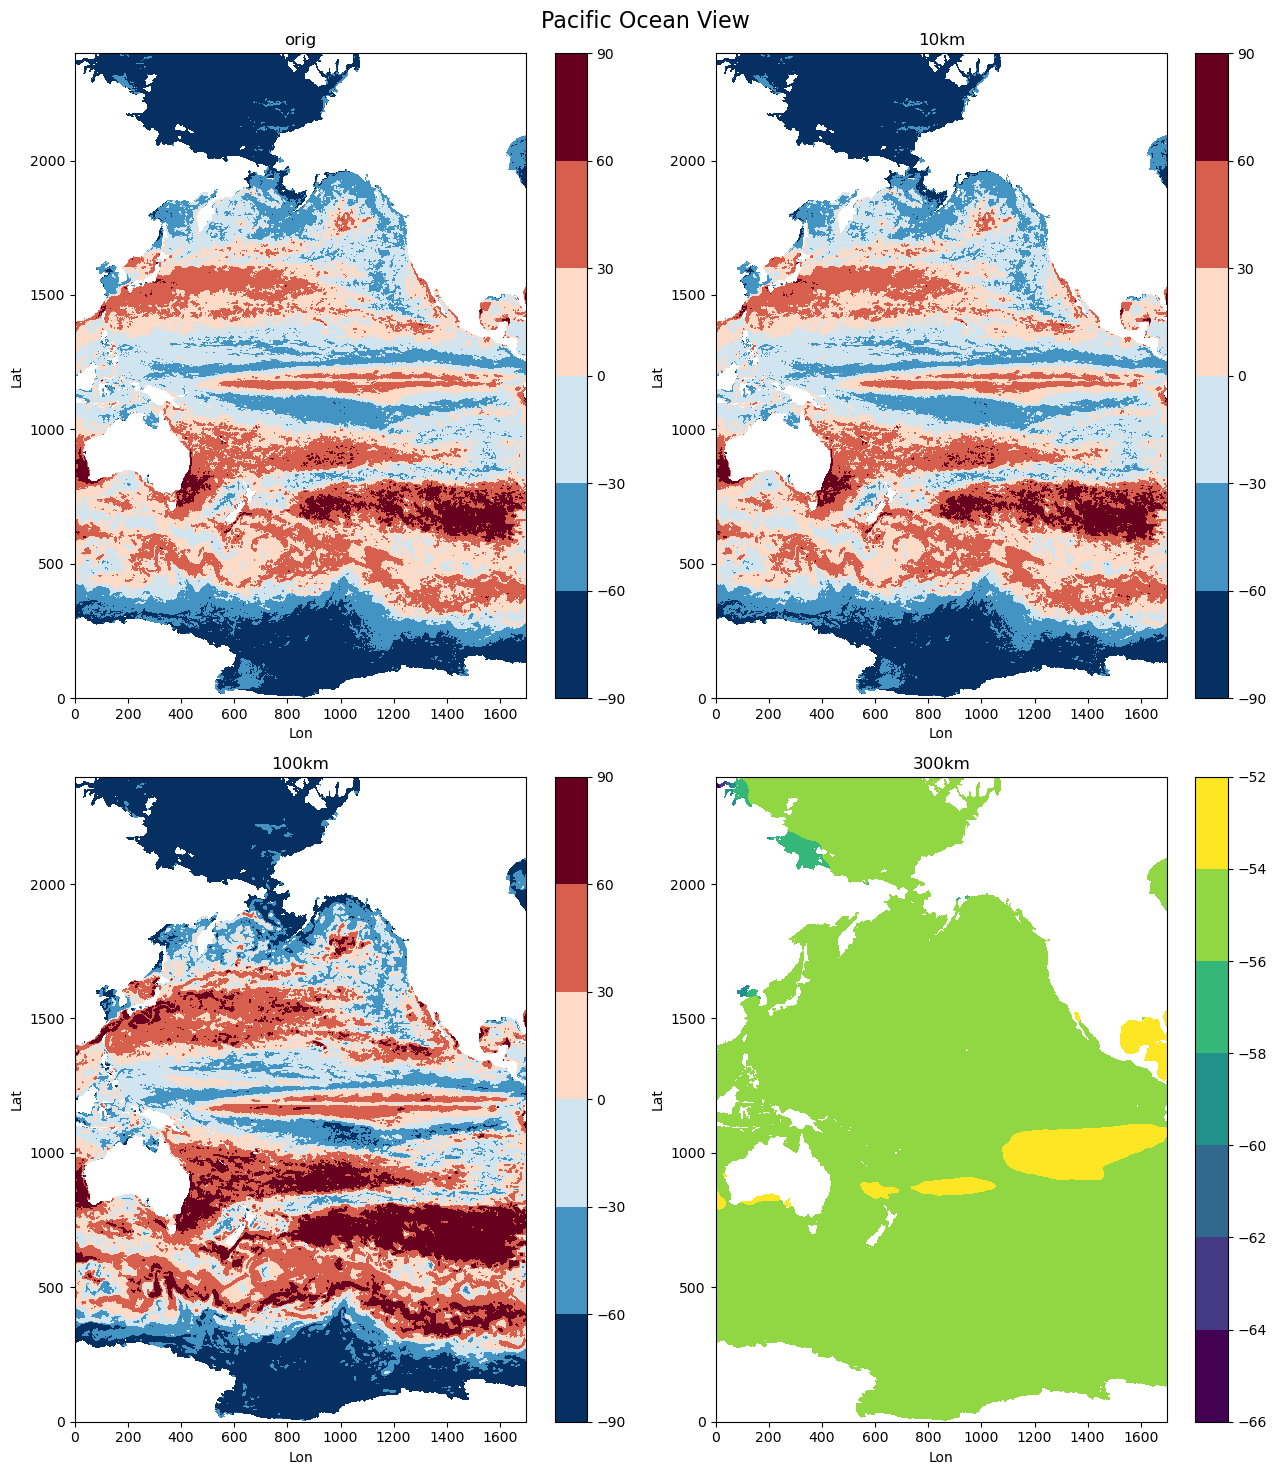

In [141]:
#PAC ocean
sel_lon = dict(nlon_t=slice(1000,2700))
hta_roll = hta_ds.roll(nlon_t=2400, roll_coords=False).isel(**sel_lon)
plot_term_titles = np.array([['orig', '10km'],['100km', '300km']])
plot_terms = xr.DataArray([[hta_roll.orig, hta_roll['10km']], [hta_roll['100km'], hta_roll['300km']]])

fig, axes = plt.subplots(2, 2, figsize=(13,15))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.plot.contourf(ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
plt.suptitle('Pacific Ocean View', fontsize=16)
plt.tight_layout();

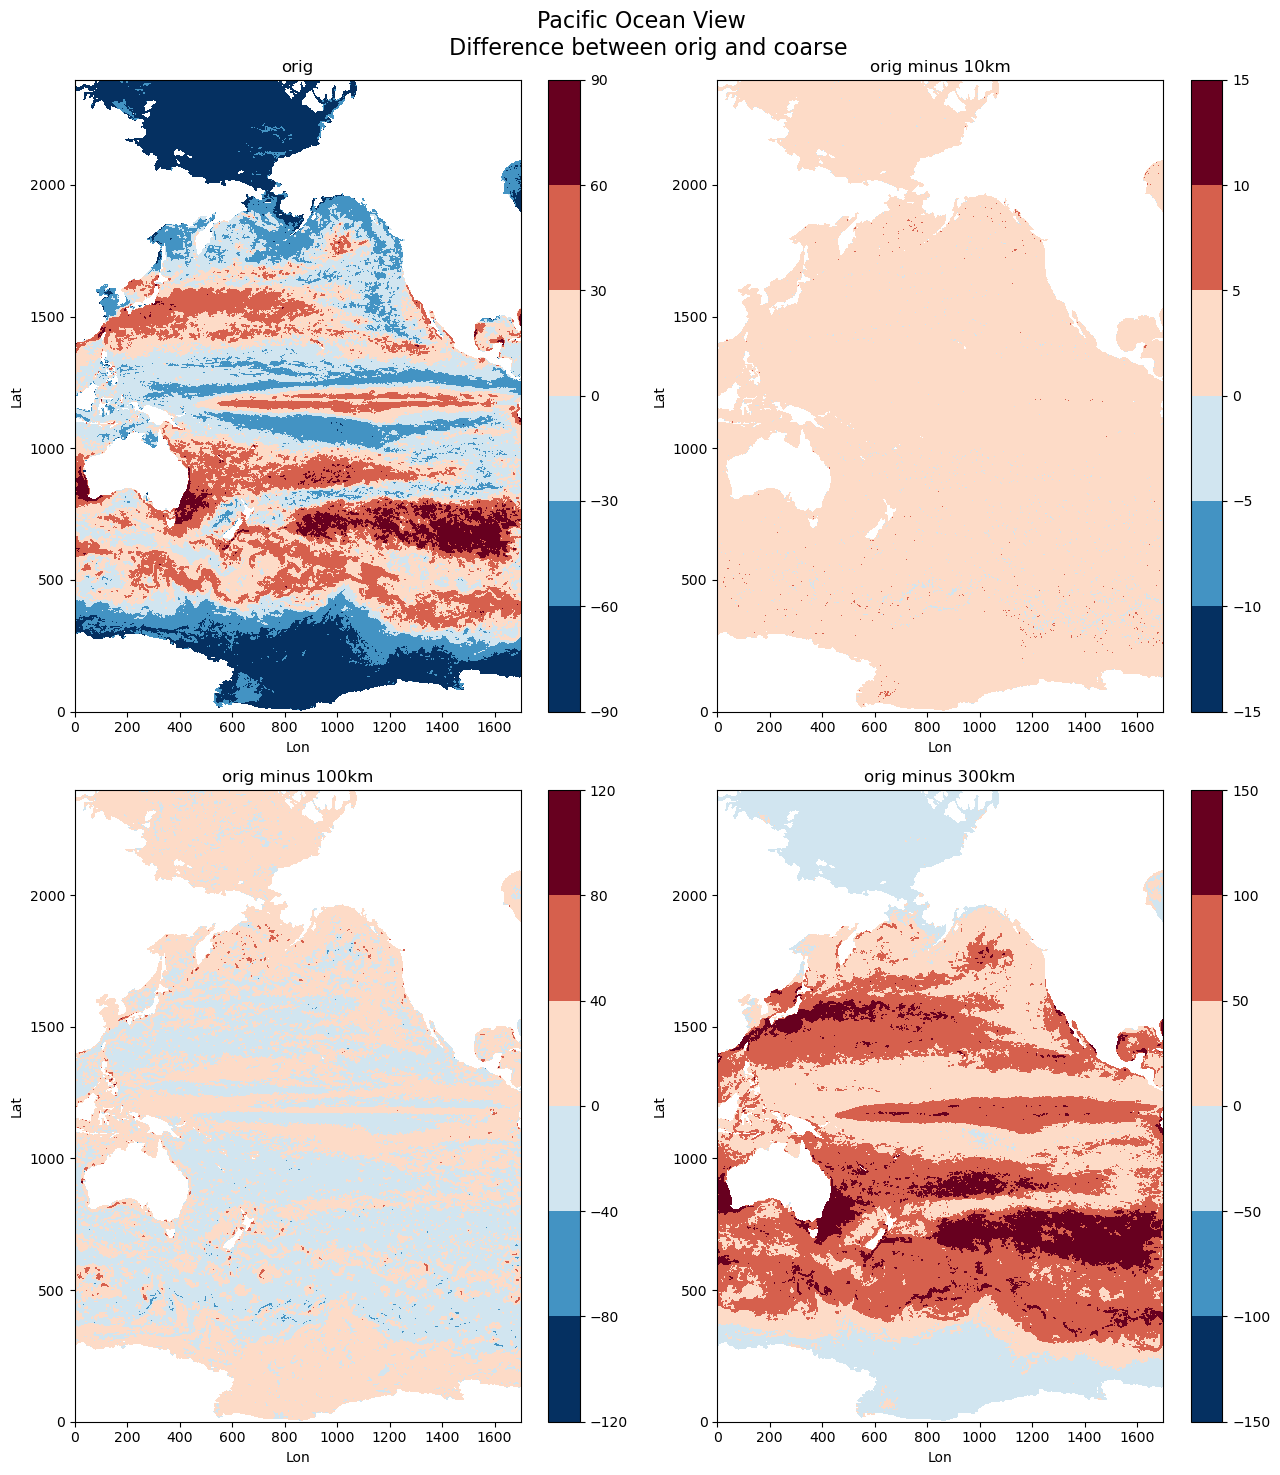

In [143]:
#PAC ocean
sel_lon = dict(nlon_t=slice(1000,2700))
hta_roll = hta_diff.roll(nlon_t=2400, roll_coords=False).isel(**sel_lon)

plot_term_titles = np.array([['orig', 'orig minus 10km'],['orig minus 100km', 'orig minus 300km']])
plot_terms = xr.DataArray([[hta_roll.orig, hta_roll.orig_10km], [hta_roll.orig_100km, hta_roll.orig_300km]])

fig, axes = plt.subplots(2, 2, figsize=(13,15))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.plot.contourf(ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
        
plt.suptitle('Pacific Ocean View \n Difference between orig and coarse', fontsize=16)
plt.tight_layout();

## Southern<a class='anchor' id='SO'> </a>

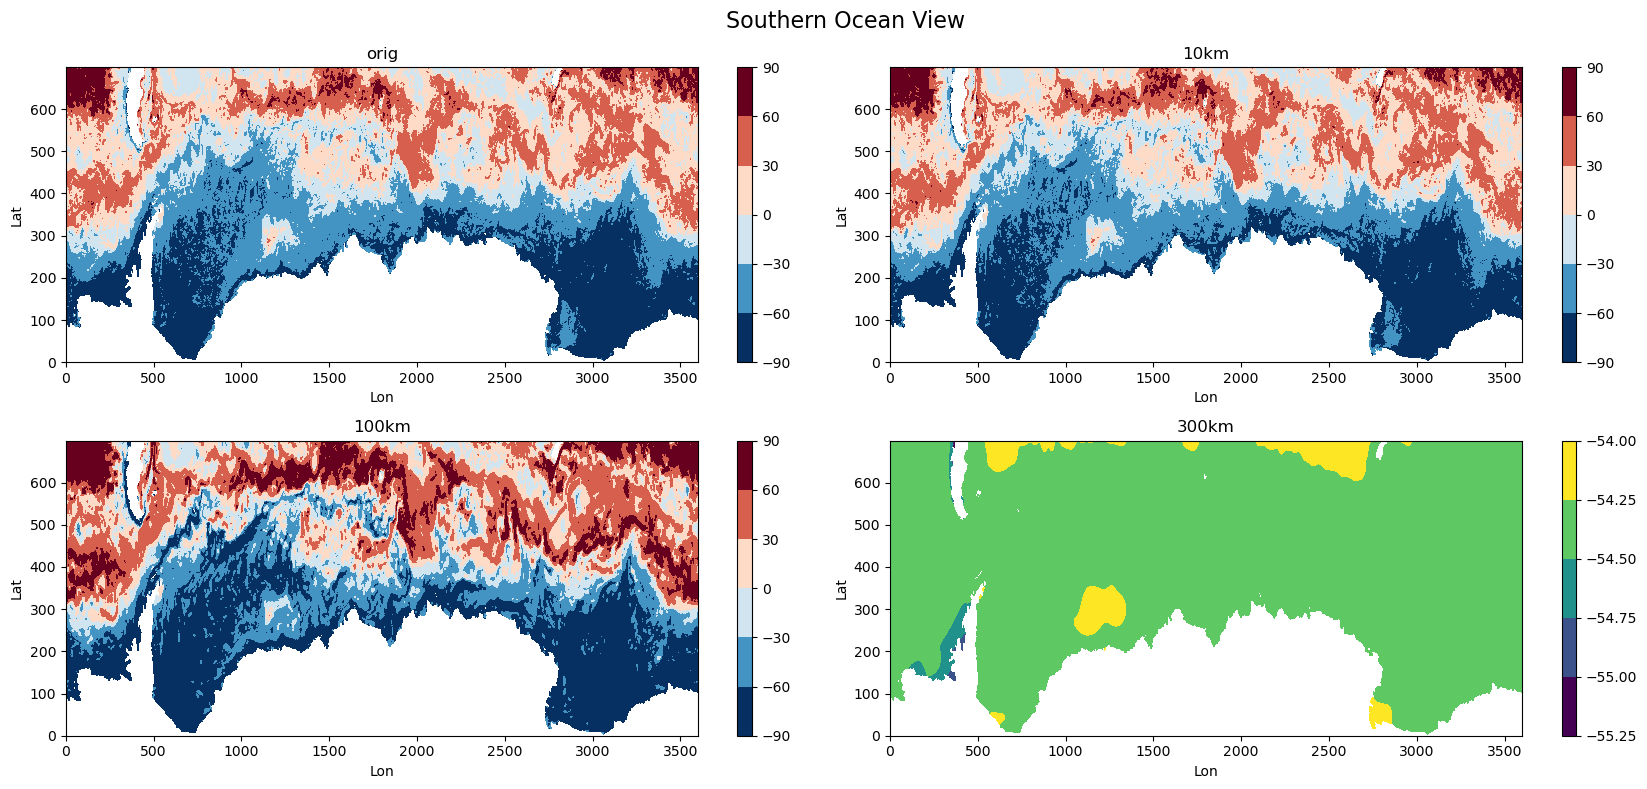

In [131]:
#SO ocean
sel_lat = dict(dim_2=slice(0, 700))
plot_term_titles = np.array([['orig', '10km'],['100km', '300km']])
plot_terms = xr.DataArray([[hta_ds.orig, hta_ds['10km']], [hta_ds['100km'], hta_ds['300km']]])

fig, axes = plt.subplots(2, 2, figsize=(17,8))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.isel(**sel_lat).plot.contourf(ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
plt.suptitle('Southern Ocean View', fontsize=16)
plt.tight_layout();

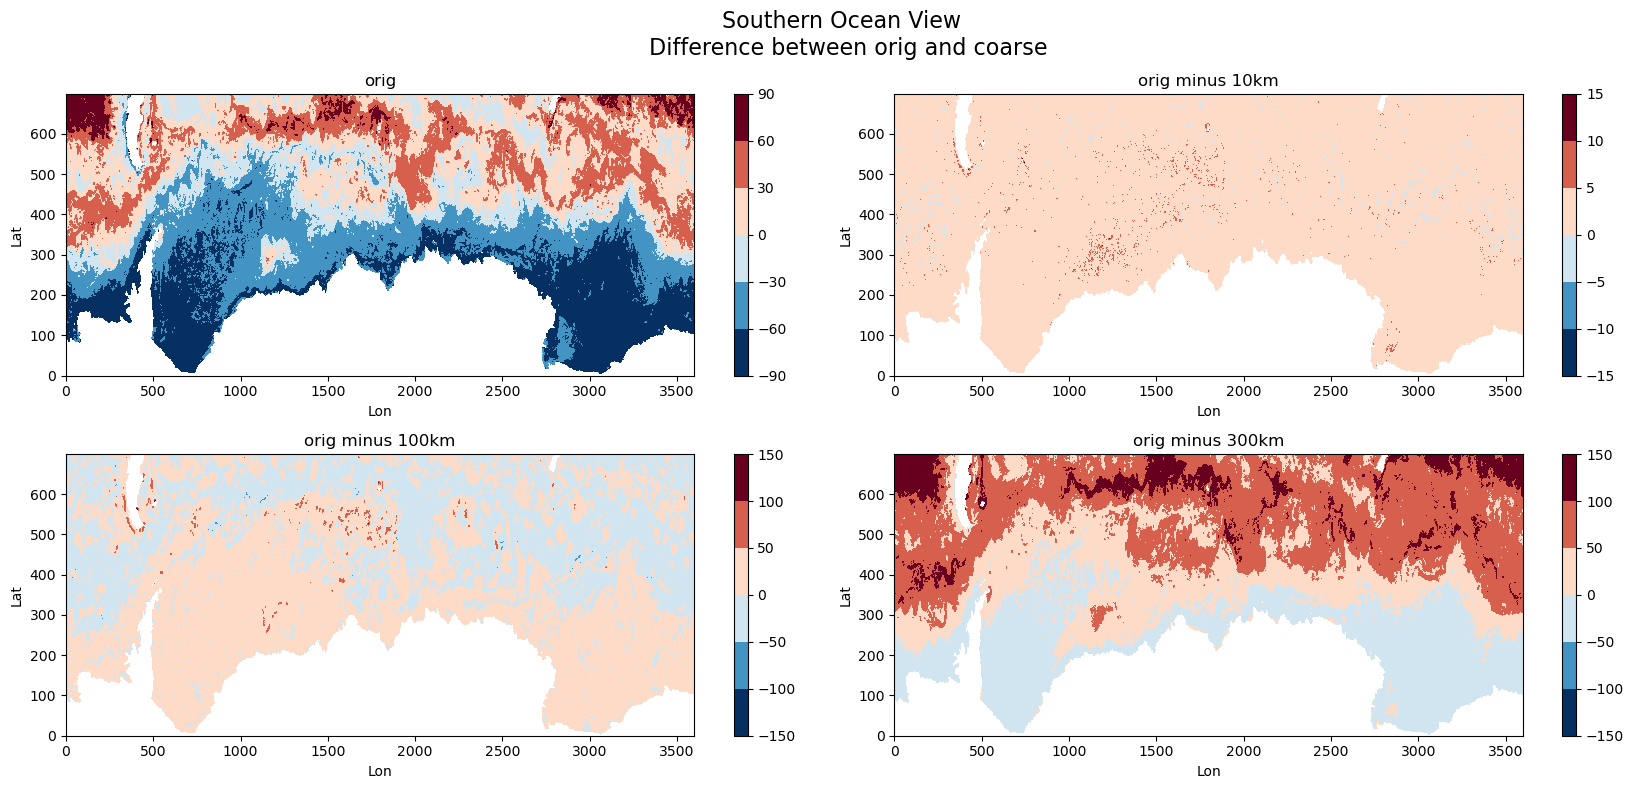

In [133]:
#SO ocean
sel_lat = dict(dim_2=slice(0, 700))
plot_term_titles = np.array([['orig', 'orig minus 10km'],['orig minus 100km', 'orig minus 300km']])
plot_terms = xr.DataArray([[hta_diff.orig, hta_diff.orig_10km], [hta_diff.orig_100km, hta_diff.orig_300km]])

fig, axes = plt.subplots(2, 2, figsize=(17,8))
for i in range(0,2):
    for j in range(0,2):
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        
        term.isel(**sel_lat).plot.contourf(ax=axes[i,j])
        axes[i,j].set_title(title)
        axes[i,j].set_ylabel('Lat')
        axes[i,j].set_xlabel('Lon')
        
plt.suptitle('Southern Ocean View \n Difference between orig and coarse', fontsize=16)
plt.tight_layout();